 20%|██        | 1/5 [04:03<16:15, 243.83s/it]


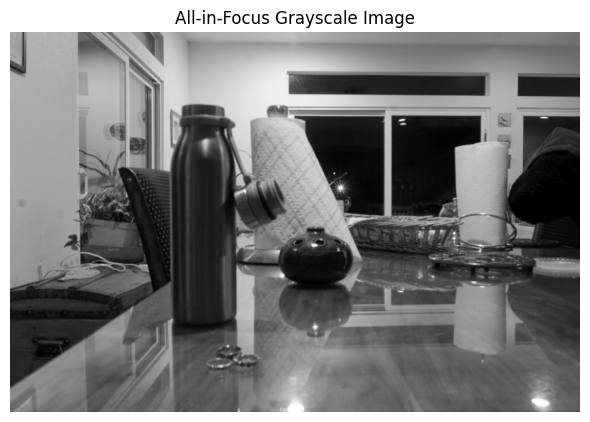

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from numpy import gradient, exp
from skimage.transform import resize
import maxflow
from tqdm import tqdm
import gc

# ----- Load Focal Stack -----
folder_path = '/Users/yannbaglinbunod/Desktop/ece 285 project/photos4'
image_filenames = sorted([
    f for f in os.listdir(folder_path)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
])

focal_stack_gray = [cv2.imread(os.path.join(folder_path, f), cv2.IMREAD_GRAYSCALE)
                    for f in image_filenames]
focal_stack_gray = [img for img in focal_stack_gray if img is not None]
focal_stack_gray = np.stack(focal_stack_gray)

# ----- Compute Common Crop Mask -----
def compute_common_crop_mask(stack):
    h, w = stack[0].shape[:2]
    mask = np.ones((h, w), dtype=np.uint8)
    for img in stack:
        edges = cv2.Canny(img, 100, 200)
        mask = cv2.bitwise_and(mask, (edges == 0).astype(np.uint8))
    return mask

common_mask = compute_common_crop_mask(focal_stack_gray)
x, y, w, h = cv2.boundingRect(common_mask.astype(np.uint8))
focal_stack_gray = np.stack([img[y:y+h, x:x+w] for img in focal_stack_gray])

# ----- Resize grayscale stack and compute focus measures -----
def compute_patchwise_gradient_stack(stack, sigma=1.0):
    return np.stack([
        np.sqrt(gx**2 + gy**2)
        for gx, gy in [gradient(gaussian_filter(f, sigma)) for f in stack]
    ])

def compute_data_term(stack, sigma=1.0):
    grad_stack = compute_patchwise_gradient_stack(stack, sigma)
    return np.stack([exp(g) for g in grad_stack])

def downsample_stack(stack, shape):
    return np.stack([resize(f, shape, anti_aliasing=True) for f in stack])

target_shape = (int(focal_stack_gray.shape[1] * 0.4), int(focal_stack_gray.shape[2] * 0.4))
focal_stack_small = downsample_stack(focal_stack_gray, target_shape)
data_cost = compute_data_term(focal_stack_small)

# ----- Alpha Expansion -----
def get_edges(H, W):
    return [(y*W+x, y*W+x+1) for y in range(H) for x in range(W-1)] + \
           [(y*W+x, (y+1)*W+x) for y in range(H-1) for x in range(W)]

def alpha_expansion(data_cost, λ=2, max_iters=5):
    N, H, W = data_cost.shape
    flat_cost = data_cost.transpose(1, 2, 0).reshape(-1, N)
    labels = np.argmin(data_cost, axis=0)
    for _ in tqdm(range(max_iters)):
        prev = labels.copy()
        flat_labels = labels.flatten()
        for α in range(N):
            g = maxflow.Graph[float]()
            nodes = g.add_nodes(H*W)
            for i in range(H*W):
                g.add_tedge(nodes[i], flat_cost[i, α], flat_cost[i, flat_labels[i]])
            for i, j in get_edges(H, W):
                pi, pj = flat_labels[i], flat_labels[j]
                g.add_edge(nodes[i], nodes[j], λ * abs(α - pj), λ * abs(α - pi))
            g.maxflow()
            for i in range(H*W):
                if g.get_segment(nodes[i]) == 0:
                    flat_labels[i] = α
            labels = flat_labels.reshape(H, W)
            del g
            gc.collect()
        if np.all(labels == prev):
            break
    return labels

label_map = alpha_expansion(data_cost)

# ----- Reconstruct All-in-Focus Image -----
H, W = label_map.shape
gray_stack_resized = np.stack([
    resize(img, label_map.shape, preserve_range=True).astype(np.uint8)
    for img in focal_stack_gray
])

output_gray = np.zeros((H, W), dtype=np.uint8)
for i in range(H):
    for j in range(W):
        output_gray[i, j] = gray_stack_resized[label_map[i, j], i, j]

# ----- Display Result -----
plt.figure(figsize=(6, 6))
plt.imshow(output_gray, cmap='gray')
plt.title("All-in-Focus Grayscale Image")
plt.axis('off')
plt.tight_layout()
plt.show()